In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import os
from datetime import datetime

# Setup
You need to have precomputed some files describing files locations in order for this notebook to run.

Take a look at notebook 1 in order to generate them.

In [2]:
datasets = ['timit', 'wavefake', 'mozilla', 'ljspeech']

In [3]:
os.makedirs('description', exist_ok=True)

# Compute Metrics for audio files across all datasets

In [4]:

# Function to calculate metrics for a single audio file
def get_audio_metrics(audio_file):
    # load
    y, sr = librosa.load(audio_file) 

    # metrics
    duration = librosa.get_duration(y=y, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    energy_distribution = librosa.feature.chroma_stft(S=np.abs(librosa.stft(y)), sr=sr)
    zero_crossings_rate = librosa.feature.zero_crossing_rate(y)

    return {
        "Audio File": audio_file,
        "Duration": duration,
        "Centroid": np.mean(centroid),
        "Rolloff": np.mean(rolloff),
        "Bandwidth": np.mean(bandwidth),
        "Energy Distribution": np.mean(energy_distribution),
        "Zero Crossings Rate": np.mean(zero_crossings_rate),
    }

In [5]:
datasets_dfs = []

# for each dataset
# compute metrics and store into a dataframe
# afterwards append to the list above
for dataset in datasets:
    print(dataset, datetime.now())
    d_file = f'{dataset}_data_files_summary.csv'
    audio_files = pd.read_csv(d_file)['full_path'].to_list()
    # Initialize an empty list to store dictionaries of metrics
    results_list = []

    # Calculate metrics for each audio file in parallel and add them to the list
    results_list = Parallel(n_jobs=8)(delayed(get_audio_metrics)(audio_file) for audio_file in audio_files)

    # Create a Pandas DataFrame from the list
    dataset_results_df = pd.DataFrame(results_list)
    dataset_results_df['dataset'] = dataset
    dataset_results_df.to_csv(f'description/{dataset}_results.csv')
    datasets_dfs.append(dataset_results_df)

# concatenate all results
results_df = pd.concat(datasets_dfs)
results_df.head()

timit 2023-11-02 12:38:35.792998
wavefake 2023-11-02 12:39:17.024790
mozilla 2023-11-02 13:04:53.237707
ljspeech 2023-11-02 15:00:38.744479


,Audio File,Duration,Centroid,Rolloff,Bandwidth,Energy Distribution,Zero Crossings Rate,dataset
0,F:\\downloads\\data\\lisa\\data\\timit\\raw\\T...,3.968027,2335.615456,3731.729287,1491.821060,0.534222,0.151821,timit
1,F:\\downloads\\data\\lisa\\data\\timit\\raw\\T...,3.628844,2193.628423,3868.295930,1589.261147,0.537498,0.137086,timit
2,F:\\downloads\\data\\lisa\\data\\timit\\raw\\T...,4.972834,2344.253735,3916.438953,1585.621424,0.515731,0.151265,timit
3,F:\\downloads\\data\\lisa\\data\\timit\\raw\\T...,3.513651,2875.386931,4698.629921,1714.758535,0.583056,0.195605,timit
4,F:\\downloads\\data\\lisa\\data\\timit\\raw\\T...,3.756825,2446.076938,4066.984049,1603.150227,0.573927,0.177074,timit


# Dataset Properties

In [6]:
results_df_g = results_df.groupby(['dataset']).agg(total_duration=('Duration', 'sum'),
                                                   n_samples=('Duration', 'count'),
                                                   mean_duration=('Duration', 'mean'),
                                                   min_duration=('Duration', 'min'),
                                                   max_duration=('Duration', 'max')
                                                   ).reset_index()
results_df_g

,dataset,total_duration,n_samples,mean_duration,min_duration,max_duration
0,ljspeech,8.611708e+04,13100,6.573823,1.110068,10.096190
1,mozilla,2.893931e+06,676640,4.276914,0.048027,14480.424036
2,timit,1.937987e+04,6300,3.076169,0.915283,7.788844
3,wavefake,7.783666e+05,134266,5.797198,0.673379,16.375011


In [7]:
results_df_d = results_df.groupby('dataset').describe()
for c in results_df.columns:
    if c not in ['dataset', 'Audio File']:
        print(c)
        display(results_df_d[c])

Duration


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,13100.0,6.573823,2.185431,1.110068,4.987800,6.764127,8.389524,10.096190
mozilla,676640.0,4.276914,17.939585,0.048027,2.904036,3.864036,5.136009,14480.424036
timit,6300.0,3.076169,0.863160,0.915283,2.496009,2.950476,3.539274,7.788844
wavefake,134266.0,5.797198,2.341897,0.673379,3.889342,5.642449,7.743855,16.375011


Centroid


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,13100.0,2620.771478,290.208562,1273.077710,2432.288003,2614.907399,2804.529487,4280.326626
mozilla,676640.0,2269.193856,616.435092,0.000000,1855.977438,2228.509283,2630.677207,8712.526071
timit,6300.0,2127.759345,270.212212,1327.192604,1933.964214,2104.664924,2297.936242,3144.596710
wavefake,134266.0,2579.078655,369.450506,1139.581551,2368.646546,2594.652022,2811.270831,4716.639382


Rolloff


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,13100.0,4481.974707,412.951750,2038.187138,4217.539829,4482.931378,4754.329006,6759.166124
mozilla,676640.0,4295.338478,1161.643073,0.000000,3524.780273,4228.959864,4991.409280,10279.228940
timit,6300.0,3717.863431,449.814333,2185.143719,3398.178532,3698.691309,4017.956981,5307.151545
wavefake,134266.0,4446.967815,509.448233,1842.482192,4143.100474,4469.468891,4775.793306,7212.132287


Bandwidth


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,13100.0,2027.869267,98.523572,1587.370701,1964.613147,2030.767779,2092.996262,2490.980578
mozilla,676640.0,2037.349637,433.114006,0.000000,1736.326719,2048.057244,2333.452451,3837.326514
timit,6300.0,1588.471335,126.239555,1143.291956,1500.294508,1586.766898,1673.569715,2065.424289
wavefake,134266.0,2045.857121,114.649698,1493.187179,1971.845433,2042.469042,2116.994258,2710.608732


Energy Distribution


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,13100.0,0.537453,0.025032,0.419343,0.521845,0.537817,0.553749,0.652320
mozilla,676640.0,0.626412,0.078201,0.000000,0.587891,0.633486,0.673358,0.947821
timit,6300.0,0.612599,0.051081,0.450133,0.577826,0.621888,0.650265,0.745832
wavefake,134266.0,0.541980,0.026800,0.379918,0.525183,0.542389,0.559299,0.693207


Zero Crossings Rate


,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ljspeech,13100.0,0.161192,0.027357,0.050682,0.143046,0.160324,0.178120,0.313716
mozilla,676640.0,0.143245,0.065944,0.000000,0.100394,0.133398,0.172869,0.923038
timit,6300.0,0.141385,0.027275,0.056580,0.122063,0.138708,0.158510,0.251619
wavefake,134266.0,0.155577,0.038442,0.024674,0.137555,0.158607,0.179117,0.371582


# Metrics Histograms across Datasets

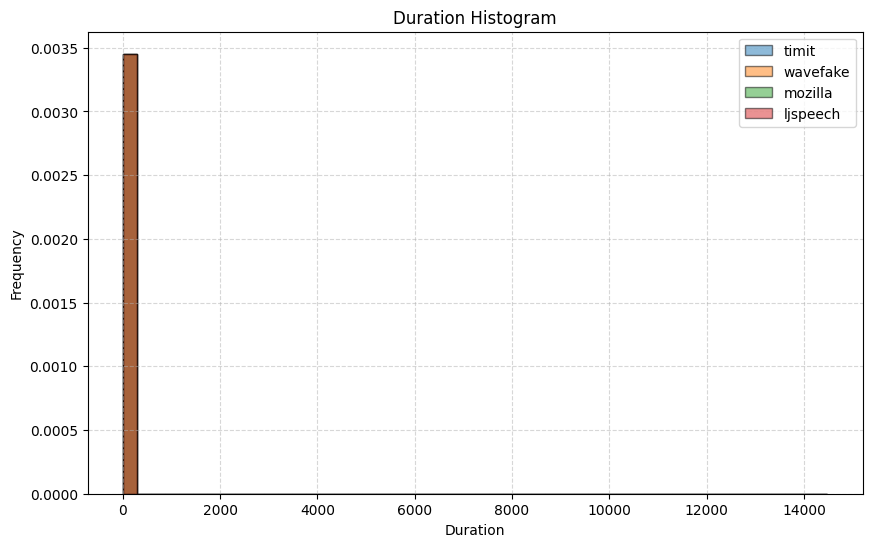

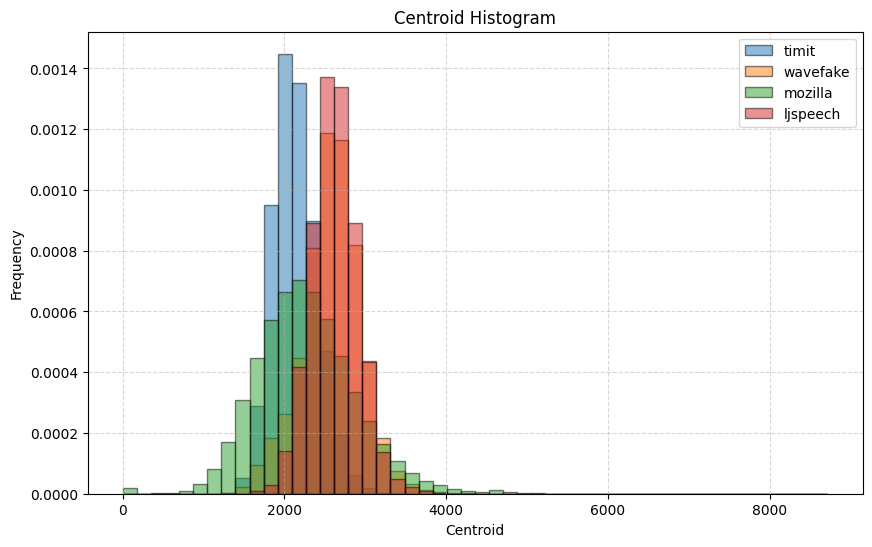

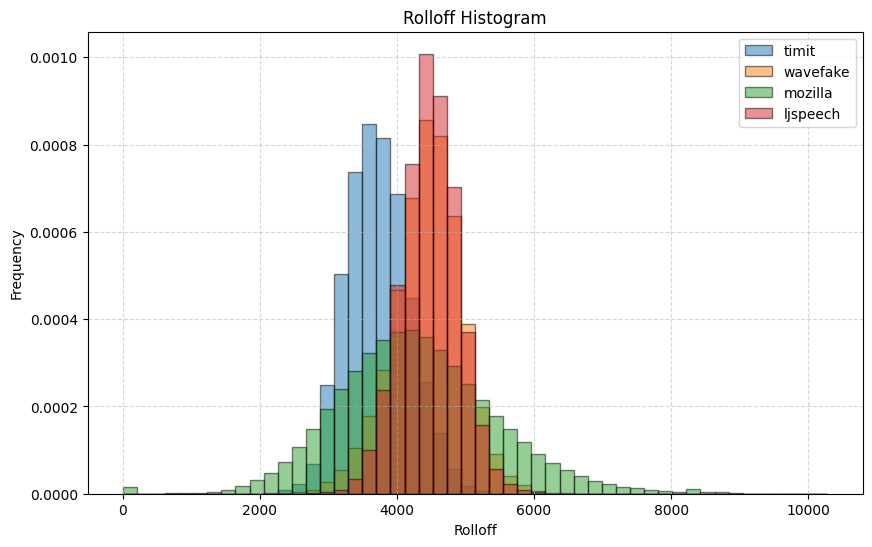

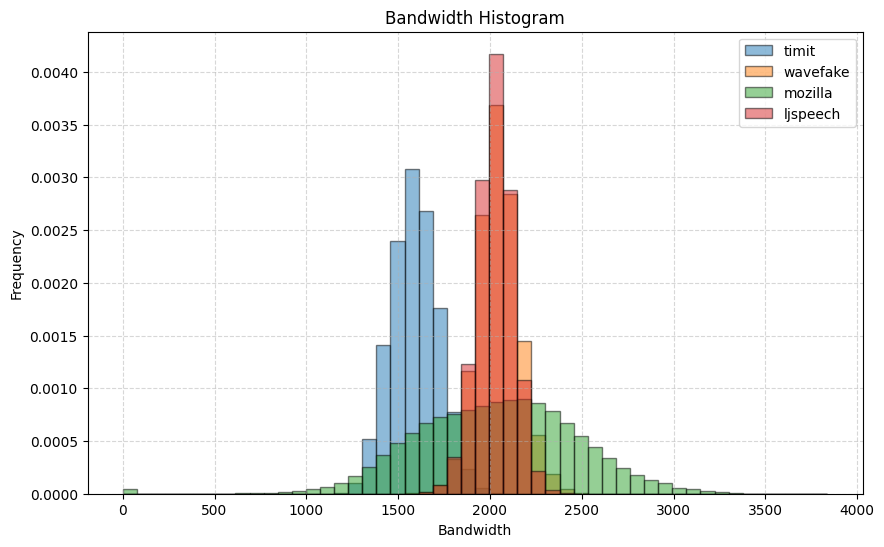

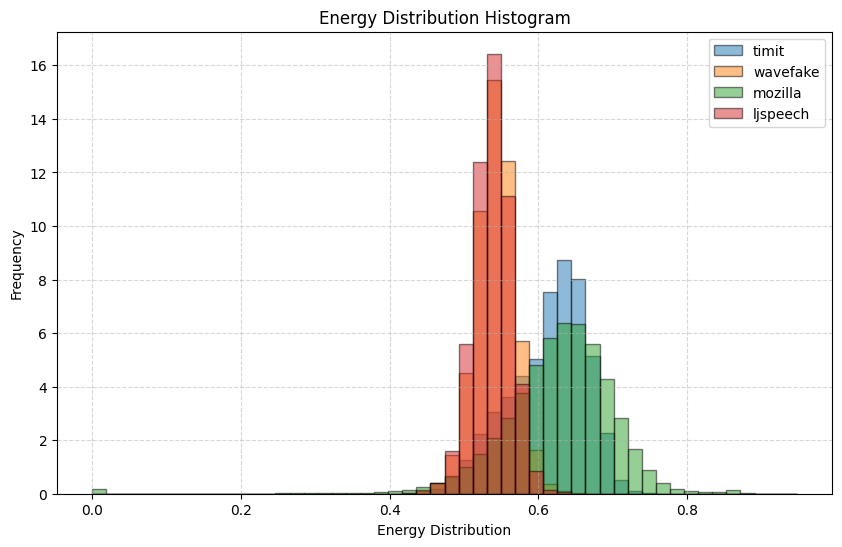

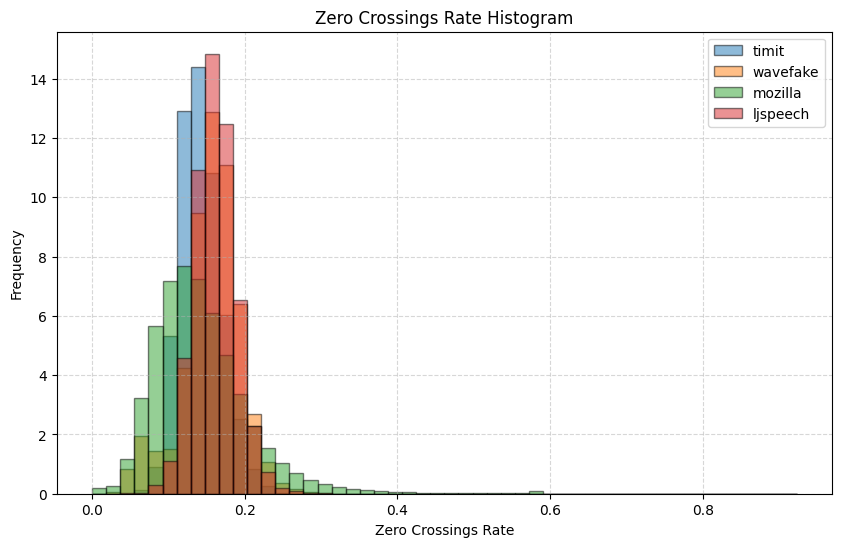

In [8]:
for metric_name in results_df.columns:
    # skip invalid columns
    if metric_name in ['Audio File', 'dataset']:
        continue
    
    num_bins = 50
    max_v = results_df[metric_name].max()
    min_v = results_df[metric_name].min()
    bin_positions = [min_v + (i * (max_v-min_v) / num_bins) for i in range(num_bins + 1)]
    plt.figure(figsize=(10, 6)) 
    for d in results_df['dataset'].unique():
        values = results_df.loc[results_df['dataset']==d, metric_name]   
        plt.hist(values,  bins=bin_positions, edgecolor='black', alpha=0.5, label=d, density=True)
    
    plt.title(f"{metric_name} Histogram")
    plt.xlabel(metric_name)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()